Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/automated-machine-learning/forecasting-bike-share/auto-ml-forecasting-bike-share.png)

# Automated Machine Learning
**BikeShare Demand Forecasting**

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Compute](#Compute)
1. [Data](#Data)
1. [Train](#Train)
1. [Featurization](#Featurization)
1. [Evaluate](#Evaluate)

## Introduction
This notebook demonstrates demand forecasting for a bike-sharing service using AutoML.

AutoML highlights here include built-in holiday featurization, accessing engineered feature names, and working with the `forecast` function. Please also look at the additional forecasting notebooks, which document lagging, rolling windows, forecast quantiles, other ways to use the forecast function, and forecaster deployment.

Make sure you have executed the [configuration notebook](../../../configuration.ipynb) before running this notebook.

Notebook synopsis:
1. Creating an Experiment in an existing Workspace
2. Configuration and local run of AutoML for a time-series model with lag and holiday features 
3. Viewing the engineered names for featurized data and featurization summary for all raw features
4. Evaluating the fitted model using a rolling test 

## Setup


In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core import Workspace, Experiment, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

This sample notebook may use features that are not available in previous versions of the Azure ML SDK.

In [2]:
print("This notebook was created using version 1.14.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.14.0 of the Azure ML SDK
You are currently using version 1.14.0 of the Azure ML SDK


As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.

In [3]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-bikeshareforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,80b2bae0-9f97-4190-a0d1-f57c078442d8
Workspace,autolmwa
SKU,Basic
Resource Group,automl
Location,westus
Run History Name,automl-bikeshareforecasting


## Compute
You will need to create a [compute target](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.
#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
amlcompute_cluster_name = "bike-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Data

The [Machine Learning service workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace) is paired with the storage account, which contains the default data store. We will use it to upload the bike share data and create [tabular dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) for training. A tabular dataset defines a series of lazily-evaluated, immutable operations to load data from the data source into tabular representation.

In [5]:
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./bike-no.csv'], target_path = 'dataset/', overwrite = True,show_progress = True)

Uploading an estimated of 1 files
Uploading ./bike-no.csv
Uploaded ./bike-no.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_34c4f6d9e36b4ba29710d81959fa619b

Let's set up what we know about the dataset. 

**Target column** is what we want to forecast.

**Time column** is the time axis along which to predict.

In [6]:
target_column_name = 'cnt'
time_column_name = 'date'

In [7]:
dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'dataset/bike-no.csv')]).with_timestamp_columns(fine_grain_timestamp=time_column_name) 
dataset.take(5).to_pandas_dataframe().reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,6,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,2,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,3,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Split the data

The first split we make is into train and test sets. Note we are splitting on time. Data before 9/1 will be used for training, and data after and including 9/1 will be used for testing.

In [8]:
# select data that occurs before a specified date
train = dataset.time_before(datetime(2012, 8, 31), include_boundary=True)
train.to_pandas_dataframe().tail(5).reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,605,2012-08-27,3,1,8,1,1,0.703333,0.654688,0.730417,0.128733,989,5928,6917
1,606,2012-08-28,3,1,8,2,1,0.728333,0.666050,0.620000,0.190925,935,6105,7040
2,607,2012-08-29,3,1,8,3,1,0.685000,0.635733,0.552083,0.112562,1177,6520,7697
3,608,2012-08-30,3,1,8,4,1,0.706667,0.652779,0.590417,0.077117,1172,6541,7713
4,609,2012-08-31,3,1,8,5,1,0.764167,0.689400,0.587500,0.168533,1433,5917,7350


In [9]:
test = dataset.time_after(datetime(2012, 9, 1), include_boundary=True)
test.to_pandas_dataframe().head(5).reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,610,2012-09-01,3,1,9,6,2,0.753333,0.702654,0.638333,0.113187,2352,3788,6140
1,611,2012-09-02,3,1,9,0,2,0.696667,0.649000,0.815000,0.064071,2613,3197,5810
2,612,2012-09-03,3,1,9,1,1,0.707500,0.661629,0.790833,0.151121,1965,4069,6034
3,613,2012-09-04,3,1,9,2,1,0.725833,0.686888,0.755000,0.236321,867,5997,6864
4,614,2012-09-05,3,1,9,3,1,0.736667,0.708983,0.741250,0.187808,832,6280,7112


## Forecasting Parameters
To define forecasting parameters for your experiment training, you can leverage the ForecastingParameters class. The table below details the forecasting parameter we will be passing into our experiment.

|Property|Description|
|-|-|
|**time_column_name**|The name of your time column.|
|**forecast_horizon**|The forecast horizon is how many periods forward you would like to forecast. This integer horizon is in units of the timeseries frequency (e.g. daily, weekly).|
|**country_or_region_for_holidays**|The country/region used to generate holiday features. These should be ISO 3166 two-letter country/region codes (i.e. 'US', 'GB').|
|**target_lags**|The target_lags specifies how far back we will construct the lags of the target variable.|
|**drop_column_names**|Name(s) of columns to drop prior to modeling|

## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**blocked_models**|Models in blocked_models won't be used by AutoML. All supported models can be found at [here](https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.constants.supportedmodels.forecasting?view=azure-ml-py).|
|**experiment_timeout_hours**|Experimentation timeout in hours.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross validation splits.|
|**enable_early_stopping**|If early stopping is on, training will stop when the primary metric is no longer improving.|
|**forecasting_parameters**|A class that holds all the forecasting related parameters.|

This notebook uses the blocked_models parameter to exclude some models that take a longer time to train on this dataset. You can choose to remove models from the blocked_models list but you may need to increase the experiment_timeout_hours parameter value to get results.

### Setting forecaster maximum horizon 

The forecast horizon is the number of periods into the future that the model should predict. Here, we set the horizon to 14 periods (i.e. 14 days). Notice that this is much shorter than the number of days in the test set; we will need to use a rolling test to evaluate the performance on the whole test set. For more discussion of forecast horizons and guiding principles for setting them, please see the [energy demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand).  

In [10]:
forecast_horizon = 14

### Config AutoML

In [11]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    country_or_region_for_holidays='US', # set country_or_region will trigger holiday featurizer
    target_lags='auto', # use heuristic based lag setting    
    drop_column_names=['casual', 'registered'] # these columns are a breakdown of the total and therefore a leak
)

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             blocked_models = ['ExtremeRandomTrees'],                             
                             experiment_timeout_hours=0.3,
                             training_data=train,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3, 
                             max_concurrent_iterations=4,
                             max_cores_per_iteration=-1,
                             verbosity=logging.INFO,
                             forecasting_parameters=forecasting_parameters)

We will now run the experiment, you can go to Azure ML portal to view the run details. 

In [12]:
remote_run = experiment.submit(automl_config, show_output=False)
remote_run

Running on remote or ADB.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-bikeshareforecasting,AutoML_54757960-0e63-456a-bb39-9c01a03f6229,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [13]:
remote_run.wait_for_completion()

{'runId': 'AutoML_54757960-0e63-456a-bb39-9c01a03f6229',
 'target': 'bike-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-10-07T20:25:56.528438Z',
 'endTimeUtc': '2020-10-07T20:46:05.195219Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'bike-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-bikeshareforecasting","subscription_id":"80b2bae0-9f97-4190-a0d1-f57c078442d8","resource_group":"automl","workspace_name":"autolmwa","region":"westus","compute_target":"bike-cluster","spark_service":null,"azure_service":"remote","_local_managed_run_id":null,"many_models":false,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_validations":3,"y_min":null,"y_max":null

### Retrieve the Best Model
Below we select the best model from all the training iterations using get_output method.

In [14]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None,
                        pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('0',
                                            Pipeline(memory=None,
                                                     steps=[('maxabsscaler',
                                                             MaxAbsScaler(copy=True)),
                                                            ('decisiontreeregressor',
                                                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                   criterion='mse',
                                                                                   max_depth=None,
                                                                                   max_features=0.8,
                                                   

## Featurization

You can access the engineered feature names generated in time-series featurization. Note that a number of named holiday periods are represented. We recommend that you have at least one year of data when using this feature to ensure that all yearly holidays are captured in the training featurization.

In [15]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['atemp',
 'atemp_WASNULL',
 'horizon_origin',
 'hum',
 'hum_WASNULL',
 'instant',
 'instant_WASNULL',
 'mnth',
 'mnth_WASNULL',
 'season',
 'season_WASNULL',
 'temp',
 'temp_WASNULL',
 'weathersit',
 'weathersit_WASNULL',
 'weekday',
 'weekday_WASNULL',
 'windspeed',
 'windspeed_WASNULL',
 'yr',
 'yr_WASNULL',
 '_automl_target_col_lag1D',
 'year',
 'year_iso',
 'half',
 'quarter',
 'month',
 'day',
 'wday',
 'qday',
 'week',
 '_IsPaidTimeOff',
 '_Holiday_1 day after Christmas Day',
 '_Holiday_1 day after Columbus Day',
 '_Holiday_1 day after Independence Day',
 '_Holiday_1 day after Labor Day',
 '_Holiday_1 day after Martin Luther King, Jr. Day',
 '_Holiday_1 day after Memorial Day',
 "_Holiday_1 day after New Year's Day",
 '_Holiday_1 day after Thanksgiving',
 '_Holiday_1 day after Veterans Day',
 "_Holiday_1 day after Washington's Birthday",
 '_Holiday_1 day before Christmas Day',
 '_Holiday_1 day before Columbus Day',
 '_Holiday_1 day before Independence Day',
 '_Holiday_1 day befo

### View the featurization summary

You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

- Raw feature name
- Number of engineered features formed out of this raw feature
- Type detected
- If feature was dropped
- List of feature transformations for the raw feature

In [16]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,atemp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
1,date,DateTime,No,105,"[MaxHorizonFeaturizer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, ...]"
2,hum,Numeric,No,2,"[MedianImputer, ImputationMarker]"
3,instant,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,mnth,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,season,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,weathersit,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,weekday,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,windspeed,Numeric,No,2,"[MedianImputer, ImputationMarker]"


## Evaluate

We now use the best fitted model from the AutoML Run to make forecasts for the test set. We will do batch scoring on the test dataset which should have the same schema as training dataset.

The scoring will run on a remote compute. In this example, it will reuse the training compute.

In [17]:
test_experiment = Experiment(ws, experiment_name + "_test")

### Retrieving forecasts from the model
To run the forecast on the remote compute we will use a helper script: forecasting_script. This script contains the utility methods which will be used by the remote estimator. We copy the script to the project folder to upload it to remote compute.

In [18]:
import os
import shutil

script_folder = os.path.join(os.getcwd(), 'forecast')
os.makedirs(script_folder, exist_ok=True)
shutil.copy('forecasting_script.py', script_folder)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/d16v3/code/Users/andrei.ciobanu/forecasting-bike-share/forecast/forecasting_script.py'

For brevity, we have created a function called run_forecast that submits the test data to the best model determined during the training run and retrieves forecasts. The test set is longer than the forecast horizon specified at train time, so the forecasting script uses a so-called rolling evaluation to generate predictions over the whole test set. A rolling evaluation iterates the forecaster over the test set, using the actuals in the test set to make lag features as needed. 

In [19]:
from run_forecast import run_rolling_forecast

remote_run = run_rolling_forecast(test_experiment, compute_target, best_run, test, target_column_name)
remote_run

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-bikeshareforecasting_test,automl-bikeshareforecasting_test_1602103602_a753342c,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [20]:
remote_run.wait_for_completion(show_output=False)

{'runId': 'automl-bikeshareforecasting_test_1602103602_a753342c',
 'target': 'bike-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-10-07T21:02:06.540659Z',
 'endTimeUtc': '2020-10-07T21:07:32.831217Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f5f4ca29-2d92-48c4-b4f6-c8422a51037b',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'da5f6cbf-7e9c-48c1-bfcd-9c41df7fe2c0'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'test_data', 'mechanism': 'Direct'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'forecasting_script.py',
  'scriptType': None,
  'useAbsolutePath': False,
  'arguments': ['--target_column_name', 'cnt'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'bike-cluster',
  'dataReferences': {},
  'data': {'test_data': {'dataLocation': {'dataset': {'id': 'da

### Download the prediction result for metrics calcuation
The test data with predictions are saved in artifact outputs/predictions.csv. You can download it and calculation some error metrics for the forecasts and vizualize the predictions vs. the actuals.

In [25]:
remote_run.download_file('outputs/predictions.csv', 'predictions.csv')
df_all = pd.read_csv('predictions.csv')

[Test data scores]

root_mean_squared_log_error:   0.598
r2_score:   0.639
normalized_root_mean_squared_error:   0.135
root_mean_squared_error:   1176.757
median_absolute_error:   763.395
normalized_median_absolute_error:   0.088
explained_variance:   0.651
normalized_mean_absolute_error:   0.107
mean_absolute_percentage_error:   194.128
spearman_correlation:   0.890
normalized_root_mean_squared_log_error:   0.101
mean_absolute_error:   931.407


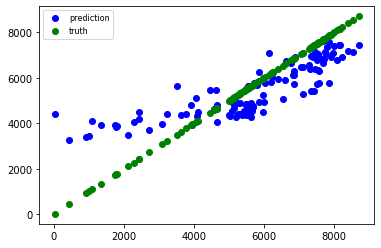

In [26]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt

# use automl metrics module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

Since we did a rolling evaluation on the test set, we can analyze the predictions by their forecast horizon relative to the rolling origin. The model was initially trained at a forecast horizon of 14, so each prediction from the model is associated with a horizon value from 1 to 14. The horizon values are in a column named, "horizon_origin," in the prediction set. For example, we can calculate some of the error metrics grouped by the horizon:

In [27]:
from metrics_helper import MAPE, APE
df_all.groupby('horizon_origin').apply(
    lambda df: pd.Series({'MAPE': MAPE(df[target_column_name], df['predicted']),
                          'RMSE': np.sqrt(mean_squared_error(df[target_column_name], df['predicted'])),
                          'MAE': mean_absolute_error(df[target_column_name], df['predicted'])}))

,MAPE,RMSE,MAE
horizon_origin,,,
1,37.74,1597.73,1535.56
2,30.38,1117.71,862.17
3,2257.40,1717.08,998.65
4,67.84,1487.02,1164.31
5,84.53,1346.24,1163.96
6,21.15,1115.84,1039.83
7,13.54,812.96,756.99
8,31.90,1188.74,981.79
9,28.04,1195.62,973.53


To drill down more, we can look at the distributions of APE (absolute percentage error) by horizon. From the chart, it is clear that the overall MAPE is being skewed by one particular point where the actual value is of small absolute value.

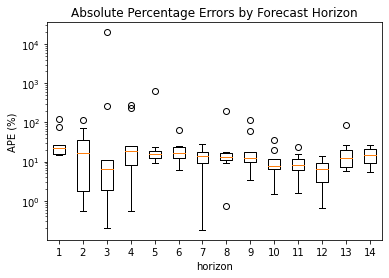

In [29]:
df_all_APE = df_all.assign(APE=APE(df_all[target_column_name], df_all['predicted']))
APEs = [df_all_APE[df_all['horizon_origin'] == h].APE.values for h in range(1, forecast_horizon + 1)]

%matplotlib inline
plt.boxplot(APEs)
plt.yscale('log')
plt.xlabel('horizon')
plt.ylabel('APE (%)')
plt.title('Absolute Percentage Errors by Forecast Horizon')

plt.show()